In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from datetime import datetime, timedelta


df = pd.read_csv('tweets.csv', encoding= 'utf-8')

In [168]:
df.head(2)

,id,handle,text,is_retweet,original_author,time,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,...,place_type,place_country_code,place_country,place_contained_within,place_attributes,place_bounding_box,source_url,truncated,entities,extended_entities
0,780925634159796224,HillaryClinton,The question in this election: Who can put the...,False,NaN,2016-09-28T00:22:34,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/Xr...,{'media': [{'display_url': 'pic.twitter.com/Xr...
1,780916180899037184,HillaryClinton,"Last night, Donald Trump said not paying taxes...",True,timkaine,2016-09-27T23:45:00,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,http://twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/t0...,{'media': [{'display_url': 'pic.twitter.com/t0...


In [169]:
df1 = df[['handle', 'text', 'is_retweet', 'time']]

In [170]:
df1.head()

,handle,text,is_retweet,time
0,HillaryClinton,The question in this election: Who can put the...,False,2016-09-28T00:22:34
1,HillaryClinton,"Last night, Donald Trump said not paying taxes...",True,2016-09-27T23:45:00
2,HillaryClinton,Couldn't be more proud of @HillaryClinton. Her...,True,2016-09-27T23:26:40
3,HillaryClinton,"If we stand together, there's nothing we can't...",False,2016-09-27T23:08:41
4,HillaryClinton,Both candidates were asked about how they'd co...,False,2016-09-27T22:30:27


In [171]:
df2 = df1.loc[df1['is_retweet'] == False]

df2 = df2.copy().reset_index(drop=True)

df2['is_trump'] = df2['handle'].apply(lambda x: 1 if x== 'realDonaldTrump' else 0) 

In [172]:
df2.head(2)

,handle,text,is_retweet,time,is_trump
0,HillaryClinton,The question in this election: Who can put the...,False,2016-09-28T00:22:34,0
1,HillaryClinton,"If we stand together, there's nothing we can't...",False,2016-09-27T23:08:41,0


In [173]:
df2['time']= pd.to_datetime(df2['time'])

In [174]:
df2['hour'] = df2['time'].apply(lambda x: int(datetime.strftime(x, "%H")))


In [175]:
df2['day of month'] = df2['time'].apply(lambda x: int(datetime.strftime(x, "%d")))
df2['month'] = df2['time'].apply(lambda x: int(datetime.strftime(x, "%m")))
df2['day of week'] = df2['time'].apply(lambda x: datetime.strftime(x, "%A"))

In [176]:
df2.head(2)

,handle,text,is_retweet,time,is_trump,hour,day of month,month,day of week
0,HillaryClinton,The question in this election: Who can put the...,False,2016-09-28 00:22:34,0,0,28,9,Wednesday
1,HillaryClinton,"If we stand together, there's nothing we can't...",False,2016-09-27 23:08:41,0,23,27,9,Tuesday


In [177]:
def binning(hours):
    if hours >= 0 and hours <=5:
        return 'Early Morning'
    elif hours >= 6 and hours <= 11:
        return 'Morning'
    elif hours >= 12 and hours <= 17:
        return 'Afternoon'
    elif hours >= 18 and hours <= 23:
        return 'Evening'
    else:
        hours = hours
    return hours

df2['section of day'] = df2['hour'].apply(binning)

In [178]:
df2.head(2)

,handle,text,is_retweet,time,is_trump,hour,day of month,month,day of week,section of day
0,HillaryClinton,The question in this election: Who can put the...,False,2016-09-28 00:22:34,0,0,28,9,Wednesday,Early Morning
1,HillaryClinton,"If we stand together, there's nothing we can't...",False,2016-09-27 23:08:41,0,23,27,9,Tuesday,Evening


In [179]:
df2['section of day'].value_counts()

Evening          1932
Afternoon        1928
Early Morning    1554
Morning           308
Name: section of day, dtype: int64

In [180]:
SectionofDay = pd.get_dummies(df2['section of day'])
DayofWeek = pd.get_dummies(df2['day of week'])
Month_ = pd.get_dummies(df2['month'], prefix='month')
DayofMonth = pd.get_dummies(df2['day of month'], prefix= 'DayofMonth')
Hour_ = pd.get_dummies(df2['hour'], prefix= 'Hour')

In [181]:
df3 = pd.concat([df2, Hour_, Month_, DayofWeek, SectionofDay, DayofMonth], axis=1)

In [182]:
df3.head(2)

,handle,text,is_retweet,time,is_trump,hour,day of month,month,day of week,section of day,...,DayofMonth_22,DayofMonth_23,DayofMonth_24,DayofMonth_25,DayofMonth_26,DayofMonth_27,DayofMonth_28,DayofMonth_29,DayofMonth_30,DayofMonth_31
0,HillaryClinton,The question in this election: Who can put the...,False,2016-09-28 00:22:34,0,0,28,9,Wednesday,Early Morning,...,0,0,0,0,0,0,1,0,0,0
1,HillaryClinton,"If we stand together, there's nothing we can't...",False,2016-09-27 23:08:41,0,23,27,9,Tuesday,Evening,...,0,0,0,0,0,1,0,0,0,0


In [183]:
def remove_punctuation(text):
    lower = text.lower()
    exclude = set(string.punctuation)
    return "".join(ch for ch in lower if ch not in exclude)

df3['processed_text'] = df2['text'].apply(remove_punctuation)

In [184]:
def remove_stopwords(x):
    lower = x.lower()
    split = lower.split()
    final = ''
    for i in split:
        if i not in stopwords.words('english'):
            final += (i + " ")
    return final

df3['processed_text1'] = df3['processed_text'].apply(remove_stopwords)

stemmer = PorterStemmer()

def split_and_stem(string):
    string = string.split(' ')
    temp = ""
    for i in string:
        temp += (stemmer.stem(i) + " ")
    return temp

df3['processed_text2'] = df3['processed_text1'].apply(split_and_stem)

In [185]:
df3.columns

Index([         u'handle',            u'text',      u'is_retweet',
                  u'time',        u'is_trump',            u'hour',
          u'day of month',           u'month',     u'day of week',
        u'section of day',          u'Hour_0',          u'Hour_1',
                u'Hour_2',          u'Hour_3',          u'Hour_4',
                u'Hour_5',          u'Hour_6',          u'Hour_7',
                u'Hour_8',          u'Hour_9',         u'Hour_10',
               u'Hour_11',         u'Hour_12',         u'Hour_13',
               u'Hour_14',         u'Hour_15',         u'Hour_16',
               u'Hour_17',         u'Hour_18',         u'Hour_19',
               u'Hour_20',         u'Hour_21',         u'Hour_22',
               u'Hour_23',         u'month_1',         u'month_2',
               u'month_3',         u'month_4',         u'month_5',
               u'month_6',         u'month_7',         u'month_8',
               u'month_9',          u'Friday',          u'Mond

Defining x & y and TTS

In [186]:
x = df3[['processed_text2', 'Hour_0','Hour_1', u'Hour_2', u'Hour_3', u'Hour_4', u'Hour_5', u'Hour_6', u'Hour_7',
                u'Hour_8',          u'Hour_9',         u'Hour_10',
               u'Hour_11',         u'Hour_12',         u'Hour_13',
               u'Hour_14',         u'Hour_15',         u'Hour_16',
               u'Hour_17',         u'Hour_18',         u'Hour_19',
               u'Hour_20',         u'Hour_21',         u'Hour_22',
               u'Hour_23',         u'month_1',         u'month_2',
               u'month_3',         u'month_4',         u'month_5',
               u'month_6',         u'month_7',         u'month_8',
               u'month_9',          u'Friday',          u'Monday',
              u'Saturday',          u'Sunday',        u'Thursday',
               u'Tuesday',       u'Wednesday',       u'Afternoon',
         u'Early Morning',         u'Evening',         u'Morning',
          u'DayofMonth_1',    u'DayofMonth_2',    u'DayofMonth_3',
          u'DayofMonth_4',    u'DayofMonth_5',    u'DayofMonth_6',
          u'DayofMonth_7',    u'DayofMonth_8',    u'DayofMonth_9',
         u'DayofMonth_10',   u'DayofMonth_11',   u'DayofMonth_12',
         u'DayofMonth_13',   u'DayofMonth_14',   u'DayofMonth_15',
         u'DayofMonth_16',   u'DayofMonth_17',   u'DayofMonth_18',
         u'DayofMonth_19',   u'DayofMonth_20',   u'DayofMonth_21',
         u'DayofMonth_22',   u'DayofMonth_23',   u'DayofMonth_24',
         u'DayofMonth_25',   u'DayofMonth_26',   u'DayofMonth_27',
         u'DayofMonth_28',   u'DayofMonth_29',   u'DayofMonth_30',
         u'DayofMonth_31']]

y = df3['is_trump']

x_train, x_test, y_train, y_test = train_test_split(x, y)

Modeling

In [187]:
tv = TfidfVectorizer()

In [188]:
df_train  = pd.DataFrame(tv.fit_transform(x_train['processed_text2']).todense(),
             columns=tv.get_feature_names())

In [189]:
df_train.index = x_train.index

In [190]:
df_test = pd.DataFrame(tv.transform(x_test['processed_text2']).todense(),
             columns=tv.get_feature_names())

In [191]:
df_test.index = x_test.index

In [192]:
df_train_combined = pd.concat([x_train[['Hour_0','Hour_1', u'Hour_2', u'Hour_3', u'Hour_4', u'Hour_5', u'Hour_6', u'Hour_7',
                u'Hour_8',          u'Hour_9',         u'Hour_10',
               u'Hour_11',         u'Hour_12',         u'Hour_13',
               u'Hour_14',         u'Hour_15',         u'Hour_16',
               u'Hour_17',         u'Hour_18',         u'Hour_19',
               u'Hour_20',         u'Hour_21',         u'Hour_22',
               u'Hour_23',         u'month_1',         u'month_2',
               u'month_3',         u'month_4',         u'month_5',
               u'month_6',         u'month_7',         u'month_8',
               u'month_9',          u'Friday',          u'Monday',
              u'Saturday',          u'Sunday',        u'Thursday',
               u'Tuesday',       u'Wednesday',       u'Afternoon',
         u'Early Morning',         u'Evening',         u'Morning',
          u'DayofMonth_1',    u'DayofMonth_2',    u'DayofMonth_3',
          u'DayofMonth_4',    u'DayofMonth_5',    u'DayofMonth_6',
          u'DayofMonth_7',    u'DayofMonth_8',    u'DayofMonth_9',
         u'DayofMonth_10',   u'DayofMonth_11',   u'DayofMonth_12',
         u'DayofMonth_13',   u'DayofMonth_14',   u'DayofMonth_15',
         u'DayofMonth_16',   u'DayofMonth_17',   u'DayofMonth_18',
         u'DayofMonth_19',   u'DayofMonth_20',   u'DayofMonth_21',
         u'DayofMonth_22',   u'DayofMonth_23',   u'DayofMonth_24',
         u'DayofMonth_25',   u'DayofMonth_26',   u'DayofMonth_27',
         u'DayofMonth_28',   u'DayofMonth_29',   u'DayofMonth_30',
         u'DayofMonth_31']], df_train], axis=1)

In [193]:
df_test_combined = pd.concat([x_test[['Hour_0','Hour_1', u'Hour_2', u'Hour_3', u'Hour_4', u'Hour_5', u'Hour_6', u'Hour_7',
                u'Hour_8',          u'Hour_9',         u'Hour_10',
               u'Hour_11',         u'Hour_12',         u'Hour_13',
               u'Hour_14',         u'Hour_15',         u'Hour_16',
               u'Hour_17',         u'Hour_18',         u'Hour_19',
               u'Hour_20',         u'Hour_21',         u'Hour_22',
               u'Hour_23',         u'month_1',         u'month_2',
               u'month_3',         u'month_4',         u'month_5',
               u'month_6',         u'month_7',         u'month_8',
               u'month_9',          u'Friday',          u'Monday',
              u'Saturday',          u'Sunday',        u'Thursday',
               u'Tuesday',       u'Wednesday',       u'Afternoon',
         u'Early Morning',         u'Evening',         u'Morning',
          u'DayofMonth_1',    u'DayofMonth_2',    u'DayofMonth_3',
          u'DayofMonth_4',    u'DayofMonth_5',    u'DayofMonth_6',
          u'DayofMonth_7',    u'DayofMonth_8',    u'DayofMonth_9',
         u'DayofMonth_10',   u'DayofMonth_11',   u'DayofMonth_12',
         u'DayofMonth_13',   u'DayofMonth_14',   u'DayofMonth_15',
         u'DayofMonth_16',   u'DayofMonth_17',   u'DayofMonth_18',
         u'DayofMonth_19',   u'DayofMonth_20',   u'DayofMonth_21',
         u'DayofMonth_22',   u'DayofMonth_23',   u'DayofMonth_24',
         u'DayofMonth_25',   u'DayofMonth_26',   u'DayofMonth_27',
         u'DayofMonth_28',   u'DayofMonth_29',   u'DayofMonth_30',
         u'DayofMonth_31']], df_test], axis=1)

In [194]:
rfc = RandomForestClassifier()

In [195]:
def run_model(x_train, y_train, x_test, y_test, model):
    rfc.fit(x_train, y_train)
    print "Base model score: " + str(np.mean(y_test))[:6]
    print "Training set score: ", str(rfc.score(x_train, y_train))[:6]
    print "Test set score: ", str(rfc.score(x_test, y_test))[:6]
    predictions = rfc.predict(x_test)
    print "\nConfusion Matrix:\n", pd.DataFrame(confusion_matrix(y_test, predictions), 
                                              columns=['predicted_0', 'predicted_1'], index=['is_0', 'is_1'])
    print "\nClassification Report:\n",classification_report(y_test, predictions)

In [196]:
run_model(df_train_combined, y_train, df_test_combined, y_test, rfc)

Base model score: 0.5324
Training set score:  0.9965
Test set score:  0.8867

Confusion Matrix:
      predicted_0  predicted_1
is_0          629           40
is_1          122          640

Classification Report:
             precision    recall  f1-score   support

          0       0.84      0.94      0.89       669
          1       0.94      0.84      0.89       762

avg / total       0.89      0.89      0.89      1431



In [197]:
predictions = rfc.predict(df_test_combined)

In [198]:
tr_acc = accuracy_score(y_test, predictions)
print("Accuracy on training set:  %.2f%%" % (100 * tr_acc))

Accuracy on training set:  88.68%


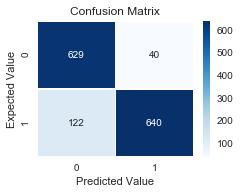

In [199]:
fig, ax = plt.subplots(figsize=(3.5,2.5))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, linewidths=.5, ax=ax, cmap="Blues", fmt="d").set(xlabel='Predicted Value', ylabel='Expected Value')
sns.plt.title('Confusion Matrix')

In [200]:
rfc_y_score = rfc.predict_proba(df_test_combined)[:,1]

In [201]:
print roc_auc_score(y_test, rfc_y_score)

0.960769197572


In [202]:
rfc_FPR = dict()
rfc_TPR = dict()
rfc_ROC_AUC = dict()

In [203]:
roc_curve(y_test, rfc_y_score)

(array([ 0.        ,  0.00149477,  0.00896861,  0.02391629,  0.05979073,
         0.12855007,  0.21375187,  0.37668161,  0.61733931,  0.8490284 ,  1.        ]),
 array([ 0.25984252,  0.48031496,  0.6312336 ,  0.75065617,  0.83989501,
         0.91207349,  0.95800525,  0.98031496,  0.99343832,  1.        ,  1.        ]),
 array([ 1. ,  0.9,  0.8,  0.7,  0.6,  0.5,  0.4,  0.3,  0.2,  0.1,  0. ]))

In [204]:
rfc_FPR[1], rfc_TPR[1], _ = roc_curve(y_test, rfc_y_score)
rfc_ROC_AUC[1] = auc(rfc_FPR[1], rfc_TPR[1])

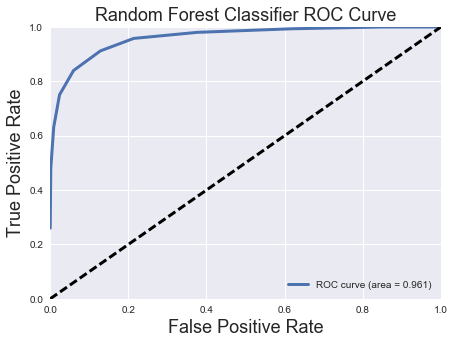

In [205]:
plt.figure(figsize=[7,5])
plt.plot(rfc_FPR[1], rfc_TPR[1], label='ROC curve (area = %0.3f)' % rfc_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Random Forest Classifier ROC Curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [206]:
rfc_feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = df_test_combined.columns,
                                    columns=['importance']).sort_values('importance',
                                    ascending=False)

In [207]:
rfc_feature_importances.head()
rfc_feature_importances.head().sum()

importance    0.128584
dtype: float64

In [208]:
# Printing Feature Importances
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

Feature ranking:


In [209]:
for f in range(df_train_combined.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

1. feature 8104 (0.033059)
2. feature 25 (0.027543)
3. feature 26 (0.024100)
4. feature 7907 (0.023735)
5. feature 30 (0.020148)
6. feature 24 (0.019772)
7. feature 32 (0.013897)
8. feature 43 (0.011962)
9. feature 2521 (0.009723)
10. feature 5889 (0.009024)
11. feature 2699 (0.008548)
12. feature 2175 (0.008043)
13. feature 6723 (0.007828)
14. feature 1494 (0.007549)
15. feature 29 (0.007479)
16. feature 31 (0.007174)
17. feature 1815 (0.006516)
18. feature 8105 (0.006129)
19. feature 6965 (0.006071)
20. feature 5774 (0.005513)
21. feature 5709 (0.005498)
22. feature 35 (0.005430)
23. feature 2332 (0.005166)
24. feature 1273 (0.004952)
25. feature 2666 (0.004906)
26. feature 544 (0.004903)
27. feature 5977 (0.004834)
28. feature 7867 (0.004804)
29. feature 8593 (0.004760)
30. feature 541 (0.004650)
31. feature 1507 (0.004622)
32. feature 5418 (0.004564)
33. feature 6226 (0.004443)
34. feature 13 (0.004276)
35. feature 11 (0.004230)
36. feature 6702 (0.004154)
37. feature 2088 (0.00411

944. feature 2336 (0.000158)
945. feature 4240 (0.000158)
946. feature 3594 (0.000158)
947. feature 2025 (0.000158)
948. feature 8192 (0.000157)
949. feature 5039 (0.000157)
950. feature 3502 (0.000157)
951. feature 2939 (0.000156)
952. feature 1388 (0.000156)
953. feature 2759 (0.000155)
954. feature 2054 (0.000155)
955. feature 868 (0.000155)
956. feature 1462 (0.000155)
957. feature 197 (0.000154)
958. feature 2133 (0.000154)
959. feature 4554 (0.000154)
960. feature 8165 (0.000154)
961. feature 6202 (0.000154)
962. feature 8170 (0.000153)
963. feature 1647 (0.000153)
964. feature 1137 (0.000153)
965. feature 6729 (0.000153)
966. feature 7696 (0.000153)
967. feature 814 (0.000153)
968. feature 614 (0.000153)
969. feature 1798 (0.000153)
970. feature 1019 (0.000152)
971. feature 3461 (0.000152)
972. feature 2745 (0.000152)
973. feature 4343 (0.000152)
974. feature 6818 (0.000152)
975. feature 4405 (0.000152)
976. feature 6884 (0.000152)
977. feature 6587 (0.000152)
978. feature 647 (

2480. feature 2696 (0.000005)
2481. feature 4742 (0.000005)
2482. feature 7292 (0.000005)
2483. feature 8547 (0.000005)
2484. feature 7685 (0.000005)
2485. feature 5590 (0.000005)
2486. feature 2701 (0.000005)
2487. feature 574 (0.000005)
2488. feature 2790 (0.000005)
2489. feature 6009 (0.000005)
2490. feature 1425 (0.000005)
2491. feature 5530 (0.000005)
2492. feature 1078 (0.000005)
2493. feature 5364 (0.000004)
2494. feature 8263 (0.000004)
2495. feature 597 (0.000004)
2496. feature 6625 (0.000004)
2497. feature 7328 (0.000004)
2498. feature 5514 (0.000004)
2499. feature 7025 (0.000004)
2500. feature 7309 (0.000004)
2501. feature 279 (0.000004)
2502. feature 8480 (0.000004)
2503. feature 3187 (0.000004)
2504. feature 3208 (0.000004)
2505. feature 4934 (0.000004)
2506. feature 5204 (0.000004)
2507. feature 451 (0.000004)
2508. feature 8590 (0.000004)
2509. feature 1022 (0.000004)
2510. feature 1915 (0.000004)
2511. feature 8239 (0.000004)
2512. feature 2962 (0.000004)
2513. feature 

3451. feature 3111 (0.000000)
3452. feature 3048 (0.000000)
3453. feature 3049 (0.000000)
3454. feature 3099 (0.000000)
3455. feature 3050 (0.000000)
3456. feature 76 (0.000000)
3457. feature 3098 (0.000000)
3458. feature 3101 (0.000000)
3459. feature 3039 (0.000000)
3460. feature 3102 (0.000000)
3461. feature 3103 (0.000000)
3462. feature 3038 (0.000000)
3463. feature 3104 (0.000000)
3464. feature 3037 (0.000000)
3465. feature 3105 (0.000000)
3466. feature 3106 (0.000000)
3467. feature 3036 (0.000000)
3468. feature 3107 (0.000000)
3469. feature 3035 (0.000000)
3470. feature 3108 (0.000000)
3471. feature 3109 (0.000000)
3472. feature 3110 (0.000000)
3473. feature 3034 (0.000000)
3474. feature 3033 (0.000000)
3475. feature 3052 (0.000000)
3476. feature 3053 (0.000000)
3477. feature 3054 (0.000000)
3478. feature 3071 (0.000000)
3479. feature 77 (0.000000)
3480. feature 3082 (0.000000)
3481. feature 78 (0.000000)
3482. feature 3080 (0.000000)
3483. feature 3079 (0.000000)
3484. feature 30

4982. feature 1573 (0.000000)
4983. feature 1574 (0.000000)
4984. feature 1575 (0.000000)
4985. feature 1576 (0.000000)
4986. feature 3470 (0.000000)
4987. feature 457 (0.000000)
4988. feature 1579 (0.000000)
4989. feature 1580 (0.000000)
4990. feature 1582 (0.000000)
4991. feature 454 (0.000000)
4992. feature 453 (0.000000)
4993. feature 1584 (0.000000)
4994. feature 1585 (0.000000)
4995. feature 1588 (0.000000)
4996. feature 1589 (0.000000)
4997. feature 1590 (0.000000)
4998. feature 450 (0.000000)
4999. feature 1618 (0.000000)
5000. feature 1620 (0.000000)
5001. feature 1622 (0.000000)
5002. feature 424 (0.000000)
5003. feature 421 (0.000000)
5004. feature 1648 (0.000000)
5005. feature 420 (0.000000)
5006. feature 1650 (0.000000)
5007. feature 418 (0.000000)
5008. feature 1654 (0.000000)
5009. feature 1655 (0.000000)
5010. feature 417 (0.000000)
5011. feature 1658 (0.000000)
5012. feature 1659 (0.000000)
5013. feature 1661 (0.000000)
5014. feature 413 (0.000000)
5015. feature 1663 (

6583. feature 7578 (0.000000)
6584. feature 7582 (0.000000)
6585. feature 7583 (0.000000)
6586. feature 7584 (0.000000)
6587. feature 7587 (0.000000)
6588. feature 7588 (0.000000)
6589. feature 7589 (0.000000)
6590. feature 7590 (0.000000)
6591. feature 7593 (0.000000)
6592. feature 7594 (0.000000)
6593. feature 7596 (0.000000)
6594. feature 7561 (0.000000)
6595. feature 7556 (0.000000)
6596. feature 7524 (0.000000)
6597. feature 7555 (0.000000)
6598. feature 7525 (0.000000)
6599. feature 7526 (0.000000)
6600. feature 7528 (0.000000)
6601. feature 7529 (0.000000)
6602. feature 7530 (0.000000)
6603. feature 7531 (0.000000)
6604. feature 7533 (0.000000)
6605. feature 7534 (0.000000)
6606. feature 7536 (0.000000)
6607. feature 7537 (0.000000)
6608. feature 7538 (0.000000)
6609. feature 7541 (0.000000)
6610. feature 7542 (0.000000)
6611. feature 7543 (0.000000)
6612. feature 7544 (0.000000)
6613. feature 7546 (0.000000)
6614. feature 7547 (0.000000)
6615. feature 7548 (0.000000)
6616. feat

8352. feature 4819 (0.000000)
8353. feature 4820 (0.000000)
8354. feature 4822 (0.000000)
8355. feature 4823 (0.000000)
8356. feature 4825 (0.000000)
8357. feature 4720 (0.000000)
8358. feature 4719 (0.000000)
8359. feature 4717 (0.000000)
8360. feature 4620 (0.000000)
8361. feature 4623 (0.000000)
8362. feature 4624 (0.000000)
8363. feature 4625 (0.000000)
8364. feature 4626 (0.000000)
8365. feature 4628 (0.000000)
8366. feature 4629 (0.000000)
8367. feature 4630 (0.000000)
8368. feature 4631 (0.000000)
8369. feature 4632 (0.000000)
8370. feature 4634 (0.000000)
8371. feature 4636 (0.000000)
8372. feature 4637 (0.000000)
8373. feature 4638 (0.000000)
8374. feature 4639 (0.000000)
8375. feature 4640 (0.000000)
8376. feature 4643 (0.000000)
8377. feature 4644 (0.000000)
8378. feature 4645 (0.000000)
8379. feature 4646 (0.000000)
8380. feature 4647 (0.000000)
8381. feature 4648 (0.000000)
8382. feature 4649 (0.000000)
8383. feature 4650 (0.000000)
8384. feature 4622 (0.000000)
8385. feat

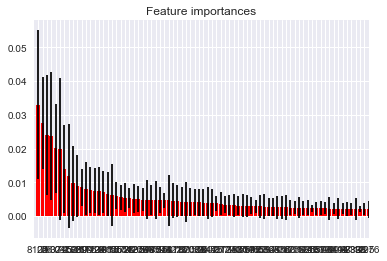

In [210]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(df_train_combined.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(df_train_combined.shape[1]), indices)
plt.xlim([-1, x.shape[1]])
plt.show()

RFC MODELING WITH ONLY TOP 10 FEATURES (FEATURES WITH >0.01% IMPORTANCE)

In [211]:
df_train_combined2 = df_train_combined[['month_1', 'month_2', 'month_3', 'trump', 'great', 'hillari', 'thank', 'Morning', 'makeamericagreatagain', 'crook']]

In [212]:
df_test_combined2 = df_test_combined[['month_1', 'month_2', 'month_3', 'trump', 'great', 'hillari', 'thank', 'Morning', 'makeamericagreatagain', 'crook']]

In [213]:
run_model(df_train_combined2, y_train, df_test_combined2, y_test, rfc)

Base model score: 0.5324
Training set score:  0.8566
Test set score:  0.7931

Confusion Matrix:
      predicted_0  predicted_1
is_0          595           74
is_1          222          540

Classification Report:
             precision    recall  f1-score   support

          0       0.73      0.89      0.80       669
          1       0.88      0.71      0.78       762

avg / total       0.81      0.79      0.79      1431



In [214]:
rfc_feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = df_train_combined2.columns,
                                    columns=['importance']).sort_values('importance',
                                    ascending=False)

In [215]:
rfc_feature_importances.head()
# rfc_feature_importances.head().sum()

,importance
trump,0.154523
hillari,0.133330
month_1,0.125184
month_2,0.123761
month_3,0.122553


In [216]:
# Printing Feature Importances
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [217]:
print("Feature ranking:")

for f in range(df_train_combined2.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 3 (0.154523)
2. feature 5 (0.133330)
3. feature 0 (0.125184)
4. feature 1 (0.123761)
5. feature 2 (0.122553)
6. feature 6 (0.114973)
7. feature 4 (0.083141)
8. feature 9 (0.063562)
9. feature 7 (0.050993)
10. feature 8 (0.027980)


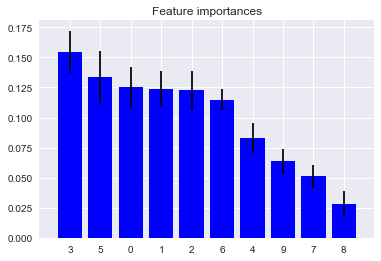

In [218]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(df_train_combined2.shape[1]), importances[indices], color="b", yerr=std[indices], align="center")
plt.xticks(range(df_train_combined2.shape[1]), indices)
plt.xlim([-1, df_train_combined2.shape[1]])
plt.show()

MODELING WITH LINEARSVC 

In [219]:
linearsvc = LinearSVC()

In [220]:
run_model(df_train_combined, y_train, df_test_combined, y_test, linearsvc)

Base model score: 0.5324
Training set score:  0.9955
Test set score:  0.8756

Confusion Matrix:
      predicted_0  predicted_1
is_0          608           61
is_1          117          645

Classification Report:
             precision    recall  f1-score   support

          0       0.84      0.91      0.87       669
          1       0.91      0.85      0.88       762

avg / total       0.88      0.88      0.88      1431

